# CycleGAN, Image-to-Image Translation

I


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#from google.colab import drive


In [ ]:
#drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/My Drive/CycleGanFirsttry.zip'

Archive:  /content/drive/My Drive/CycleGanFirsttry.zip
  inflating: CycleGAN_Solution (Fardad).ipynb  
  inflating: Evaluation_CycleGAN_Solution1.ipynb  
  inflating: helpers1.py             


In [ ]:
!unzip "/content/drive/My Drive/data.zip"

In [ ]:
# loading in and transforming data
import os
import tensorflow as tf
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pickle
# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings
import datetime
%matplotlib inline

In [ ]:
path=os.getcwd()
path

'/content'

In [ ]:

#print(os.listdir('/content/drive/My Drive/Colab Notebooks/New_seb_T1T2'))
# os.chdir('/content/drive/My Drive/Colab Notebooks/New_seb_T1T2')
# os.listdir()

In [ ]:
def get_data_loader(image_type, image_dir='data',
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'.
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """

    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


    return train_loader, test_loader



In [ ]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='T1')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='T1')

1125


(-0.5, 1041.5, 261.5, -0.5)

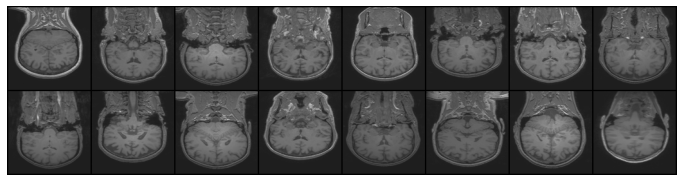

In [ ]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some images from X
dataiter = iter(dataloader_X)
print(len(dataiter))
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images

fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))
plt.axis('off')



In [ ]:
#dataiter = iter(dataloader_Y)
#dataloader_Y, test_dataloader_Y = get_data_loader(image_type='T2')
images.shape

torch.Size([16, 3, 128, 128])

In [ ]:
out = torch.nn.functional.interpolate(images, size=(64, 64), mode='bicubic', align_corners=False)
print(out.shape)

out1=torch.nn.ZeroPad2d
target = torch.zeros(16, 3, 128,128)
print(target.shape)
target[:,:,32:96,32:96]=out
print(target.shape)

torch.Size([16, 3, 64, 64])
torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


In [ ]:
# import torch.nn.functional as nnf

# x = torch.rand(5, 1, 44, 44)

# out = torch.nn.functional.interpolate(x, size=(224, 224), mode='bicubic', align_corners=False)

# out.shape

372


(-0.5, 1041.5, 261.5, -0.5)

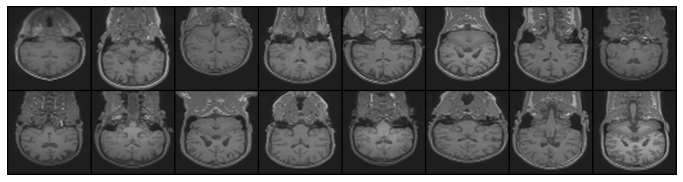

In [ ]:
# get some images from Y
dataiter = iter(test_dataloader_Y)
print(len(dataiter))
images, _ = dataiter.next()
images1 = torch.nn.functional.interpolate(images, size=(64, 64), mode='bicubic', align_corners=False)
images = torch.nn.functional.interpolate(images1, size=(128, 128), mode='bicubic', align_corners=False)
#print(target.shape)
#target[:,:,32:96,32:96]=images
# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))
plt.axis('off')

In [ ]:
images.shape

torch.Size([16, 3, 128, 128])

In [ ]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0525)
Max:  tensor(0.6815)


In [ ]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1.
       This function assumes that the input x is already scaled from 0-1.'''

    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [ ]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.8950)
Scaled max:  tensor(0.3631)


In [ ]:
net= torch.load('/content/drive/My Drive/Cycle_checkpoint/G_XtoY.pkl')

In [ ]:
predict=net.get(test_dataloader_X)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)

        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

In [ ]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs

        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3

        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim,
                                kernel_size=3, stride=1, padding=1, batch_norm=True)

        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim,
                               kernel_size=3, stride=1, padding=1, batch_norm=True)

    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2


In [ ]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [ ]:
class CycleGenerator(nn.Module):

    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator

        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim*1, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim*1, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

In [ ]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""

    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [ ]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


In [ ]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()


# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss


In [ ]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [ ]:
os.listdir()

['.config',
 'data',
 'drive',
 'Evaluation_CycleGAN_Solution1.ipynb',
 'CycleGAN_Solution (Fardad).ipynb',
 'helpers1.py',
 'sample_data']

In [ ]:
# import save code
#import helpers1
from helpers1 import save_samples, checkpoint

In [ ]:
# train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y,
                  n_epochs=2):



    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_X)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_X)
    batches_per_epoch = min(len(iter_X), len(iter_Y))
    n_epochs=n_epochs*batches_per_epoch
    print(n_epochs)
    for epoch in range(1, n_epochs + 1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter_X

        images_XY, _ = iter_X.next()
        images_X = scale(images_XY) # make sure to scale to a range -1 to 1
        images_X1 = torch.nn.functional.interpolate(images_X, size=(64, 64), mode='bicubic', align_corners=False)
        images_X = torch.nn.functional.interpolate(images_X1, size=(128, 128), mode='bicubic', align_corners=False)

       # print(images_X.shape)

        images_Y = images_XY
        images_Y = scale(images_Y)

        #target = torch.zeros(16, 3, 128,128)
        #print(target.shape)
        #target[:,:,32:96,32:96]=images_Y
        #images_Y=target
        #images_Y = torch.nn.functional.interpolate(images_Y, size=(64, 64), mode='bicubic', align_corners=False)
        #print(images_Y.shape)
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)
       # print(images_Y.shape())

        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)

        # Train with fake images

        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)


        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()


        ##   Second: D_Y, real and fake loss components   ##

        # Train with real images
        d_y_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)

        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()

        print_every=100
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))


        #sample_every=1000
        # Save the generated samples
        if epoch % batches_per_epoch == 0:
            print(datetime.datetime.now())
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(int(epoch/batches_per_epoch), fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)

            #save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

            checkpoint(int(epoch/batches_per_epoch), G_XtoY, G_YtoX, D_X, D_Y)
        # uncomment these lines, if you want to save your model
        #checkpoint_every=50
        # Save the model parameters
        #if epoch % checkpoint_every == 0:
            #checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [ ]:
n_epochs = 40 # keep this small when testing if a model first works
print(datetime.datetime.now())
losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

2020-05-12 14:24:36.662692
45000
Epoch [  100/45000] | d_X_loss: 0.4841 | d_Y_loss: 0.3700 | g_total_loss: 3.0017
Epoch [  200/45000] | d_X_loss: 0.3702 | d_Y_loss: 0.7653 | g_total_loss: 2.6269
Epoch [  300/45000] | d_X_loss: 0.4099 | d_Y_loss: 0.3962 | g_total_loss: 2.4071
Epoch [  400/45000] | d_X_loss: 0.3005 | d_Y_loss: 0.1387 | g_total_loss: 2.3384
Epoch [  500/45000] | d_X_loss: 0.2123 | d_Y_loss: 0.2361 | g_total_loss: 3.3245
Epoch [  600/45000] | d_X_loss: 0.4214 | d_Y_loss: 0.2027 | g_total_loss: 2.7416
Epoch [  700/45000] | d_X_loss: 0.2675 | d_Y_loss: 0.2340 | g_total_loss: 2.6240
Epoch [  800/45000] | d_X_loss: 0.3353 | d_Y_loss: 0.2454 | g_total_loss: 2.9099
Epoch [  900/45000] | d_X_loss: 0.2845 | d_Y_loss: 0.3521 | g_total_loss: 2.5372
Epoch [ 1000/45000] | d_X_loss: 0.3149 | d_Y_loss: 0.2107 | g_total_loss: 2.2574
Epoch [ 1100/45000] | d_X_loss: 0.2280 | d_Y_loss: 0.1709 | g_total_loss: 2.1149
2020-05-12 14:30:55.087728
Saved /content/drive/My Drive/Cycle_Sample/sample

In [ ]:
images_Y


NameError: ignored

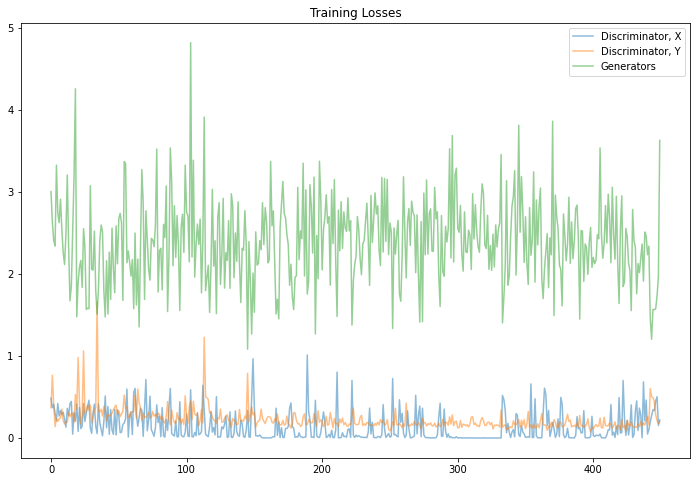

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='/content/drive/My Drive/Cycle_Sample'):

    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))

    # read in those samples
    try:
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')

    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


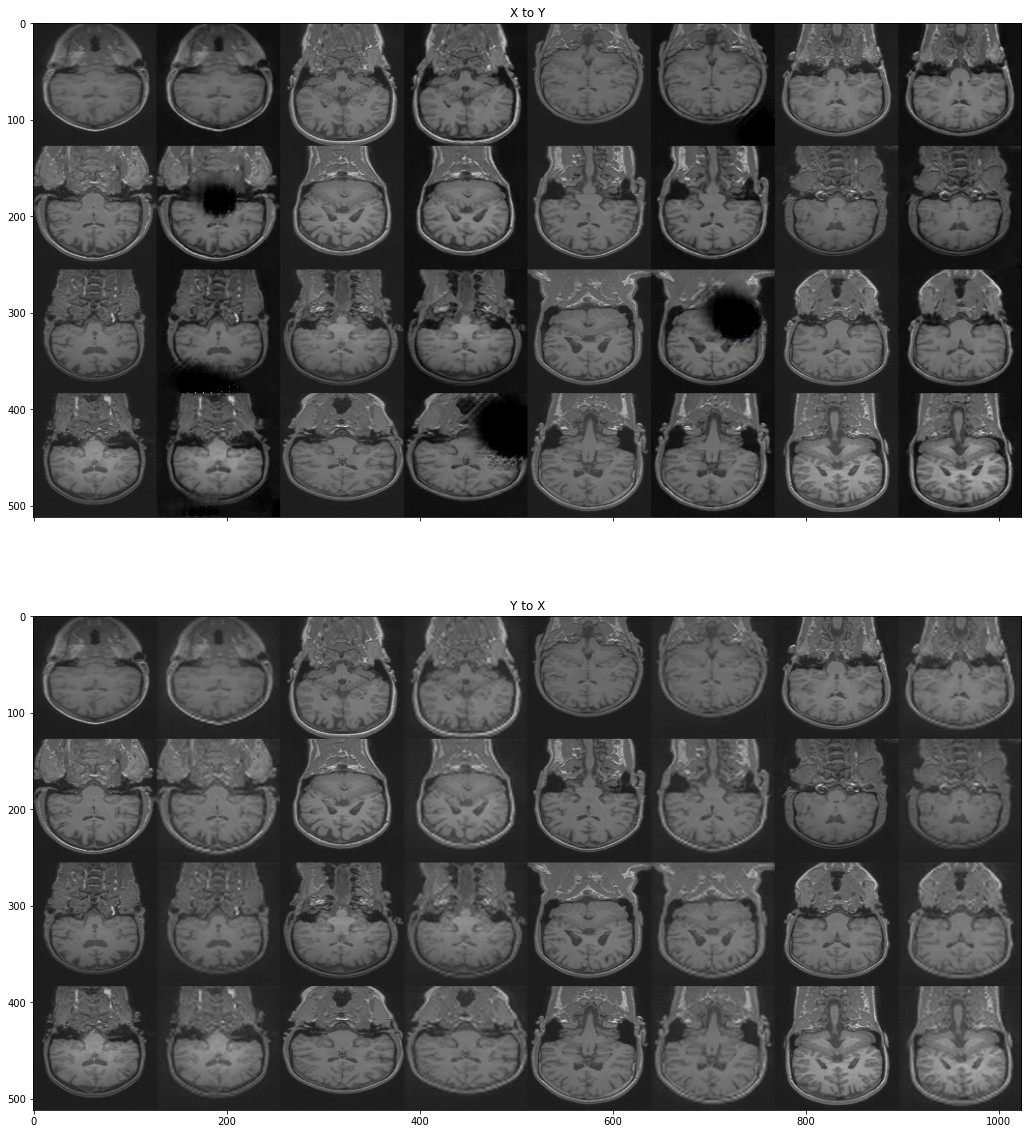

In [ ]:
# view samples at iteration 100
view_samples(40, '/content/drive/My Drive/Cycle_Sample')

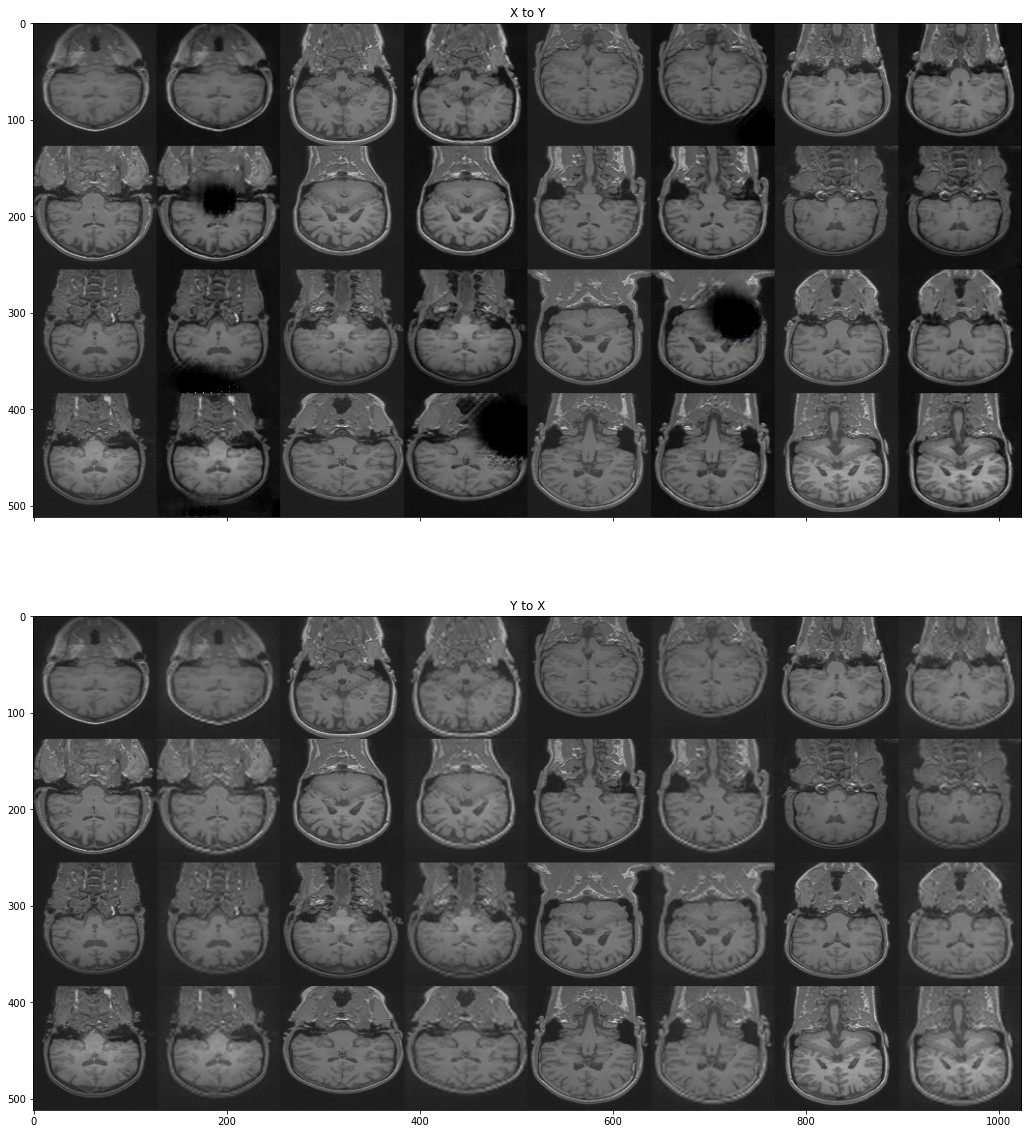

In [ ]:
# view samples at iteration 4000
view_samples(40, '/content/drive/My Drive/Cycle_Sample')

In [ ]:
test_iter_X=iter(test_dataloader_X)
test_iter_Y=iter(test_dataloader_X)



Text(0.5, 1.0, 'Real X')

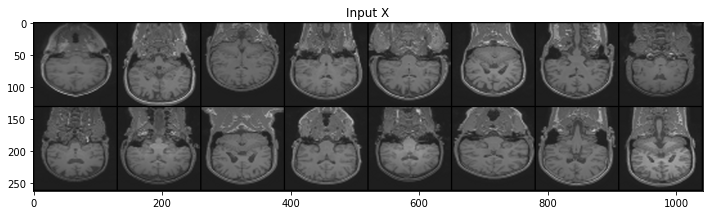

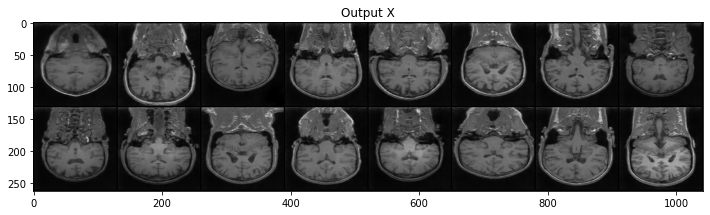

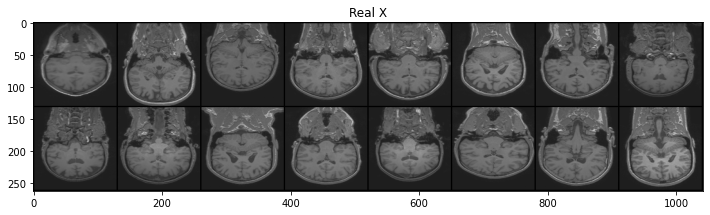

In [ ]:
def to_data(x):
  """Converts variable to numpy."""
  if torch.cuda.is_available():
      x = x.cpu()
  x = x.data.numpy()
  x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
  return x



def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#test_iter_Y = iter(test_dataloader_Y)
#test_iter_X = iter(test_dataloader_X)


fixed_X = test_iter_X.next()[0]
fixed_Y = fixed_X
#images_X = scale(fixed_X)
images_X=fixed_X
#images_Y, _ = test_iter_Y.next()
#images_X = scale(images_XY) # make sure to scale to a range -1 to 1
images_X1 = torch.nn.functional.interpolate(images_X, size=(64, 64), mode='bicubic', align_corners=False)
images_X = torch.nn.functional.interpolate(images_X1, size=(128, 128), mode='bicubic', align_corners=False)
fig = plt.figure(figsize=(12, 8))
#fig, (ax1, ax2) = plt.subplots
imshow(torchvision.utils.make_grid(images_X))

plt.title('Input X')


#images_Y = scale(fixed_Y)
fake_X = G_XtoY(images_X.to(device))
fake_X = to_data(fake_X)

fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(torch.from_numpy(fake_X)))
plt.title('Output X')

#fixed_X = test_iter_X.next()[0]
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(fixed_X))
plt.title('Real X')

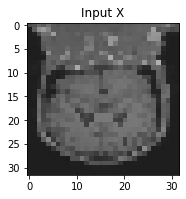

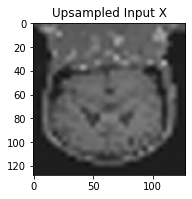

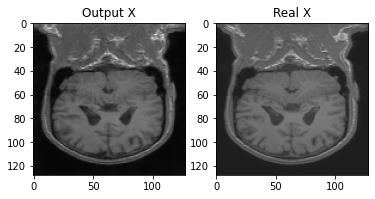

In [ ]:
S = 10
#fake_X=fake_X.numpy()

fixed_X1=fixed_X.numpy()
images_Xr=fixed_X
#images_Y, _ = test_iter_Y.next()
#images_X = scale(images_XY) # make sure to scale to a range -1 to 1
images_X1 = torch.nn.functional.interpolate(images_Xr, size=(32, 32), mode='bicubic', align_corners=False)
images_X = torch.nn.functional.interpolate(images_X1, size=(128, 128), mode='bicubic', align_corners=False)


images_X1=images_X1.numpy()
plt.figure()
fixed_Y1 = np.transpose(images_X1[S,:,:,:], (1, 2, 0))
plt.subplot(1,2,1)
plt.title('Input X')
plt.imshow(fixed_Y1)


images_X=images_X.numpy()
plt.figure()
fixed_Y1 = np.transpose(images_X[S,:,:,:], (1, 2, 0))
plt.subplot(1,2,1)
plt.title('Upsampled Input X')
plt.imshow(fixed_Y1)


fake1 = np.transpose(fake_X[S,:,:,:], (1, 2, 0))
fixed1 = np.transpose(fixed_X1[S,:,:,:], (1, 2, 0))
plt.figure()
plt.subplot(1,2,1)
plt.title('Output X')
plt.imshow(fake1)
plt.subplot(1,2,2)
plt.title('Real X')
plt.imshow(fixed1)



def correlation_coefficient(patch1, patch2):
    num = np.sum((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    den = np.sqrt(np.sum(np.square(patch1 - patch1.mean())) * np.sum(np.square(patch2 - patch2.mean())))
    if den == 0:
        return 0
    else:
        product = num/den
        return product




# cor = correlation_coefficient (fixed_Y1[:,:,0], fixed1[:,:,0])
# print('Correlation between Fake Input X and Real X: ',cor)

# cor1 = correlation_coefficient (fake1[:,:,0], fixed1[:,:,0])
# print('Correlation between Fake Output X and Real X: ',cor1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Real X')

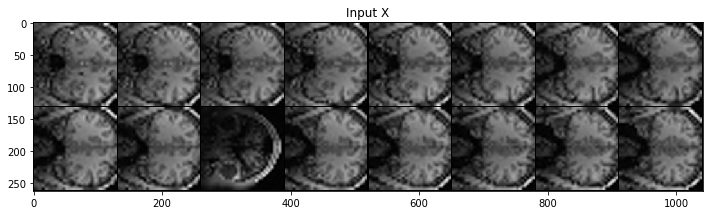

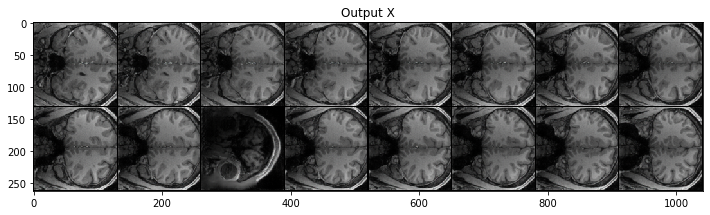

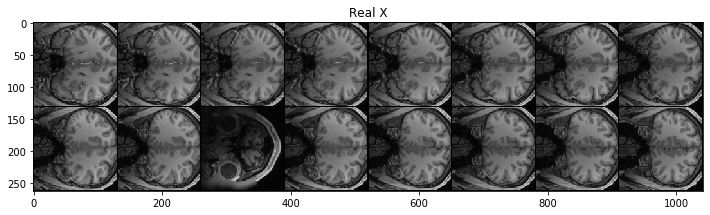

In [ ]:
def to_data(x):
  """Converts variable to numpy."""
  if torch.cuda.is_available():
      x = x.cpu()
  x = x.data.numpy()
  x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
  return x



def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#test_iter_Y = iter(test_dataloader_Y)
#test_iter_X = iter(test_dataloader_X)


fixed_X = test_iter_X.next()[0]
fixed_Y = fixed_X
#images_X = scale(fixed_X)
images_X=fixed_X
#images_Y, _ = test_iter_Y.next()
#images_X = scale(images_XY) # make sure to scale to a range -1 to 1
images_X1 = torch.nn.functional.interpolate(images_X, size=(32, 32), mode='bicubic', align_corners=False)
images_X = torch.nn.functional.interpolate(images_X1, size=(128, 128), mode='bicubic', align_corners=False)
fig = plt.figure(figsize=(12, 8))
#fig, (ax1, ax2) = plt.subplots
imshow(torchvision.utils.make_grid(images_X))

plt.title('Input X')


#images_Y = scale(fixed_Y)
fake_X = G_XtoY(images_X.to(device))
fake_X = to_data(fake_X)

fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(torch.from_numpy(fake_X)))
plt.title('Output X')

#fixed_X = test_iter_X.next()[0]
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(fixed_X))
plt.title('Real X')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


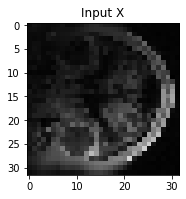

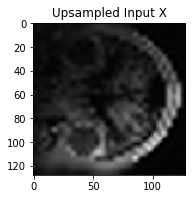

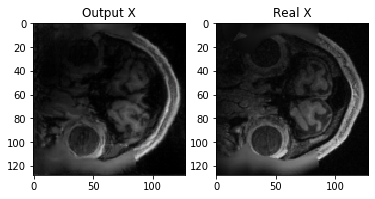

In [ ]:
S = 10
#fake_X=fake_X.numpy()

fixed_X1=fixed_X.numpy()
images_Xr=fixed_X
#images_Y, _ = test_iter_Y.next()
#images_X = scale(images_XY) # make sure to scale to a range -1 to 1
images_X1 = torch.nn.functional.interpolate(images_Xr, size=(32, 32), mode='bicubic', align_corners=False)
images_X = torch.nn.functional.interpolate(images_X1, size=(128, 128), mode='bicubic', align_corners=False)


images_X1=images_X1.numpy()
plt.figure()
fixed_Y1 = np.transpose(images_X1[S,:,:,:], (1, 2, 0))
plt.subplot(1,2,1)
plt.title('Input X')
plt.imshow(fixed_Y1)


images_X=images_X.numpy()
plt.figure()
fixed_Y1 = np.transpose(images_X[S,:,:,:], (1, 2, 0))
plt.subplot(1,2,1)
plt.title('Upsampled Input X')
plt.imshow(fixed_Y1)


fake1 = np.transpose(fake_X[S,:,:,:], (1, 2, 0))
fixed1 = np.transpose(fixed_X1[S,:,:,:], (1, 2, 0))
plt.figure()
plt.subplot(1,2,1)
plt.title('Output X')
plt.imshow(fake1)
plt.subplot(1,2,2)
plt.title('Real X')
plt.imshow(fixed1)



def correlation_coefficient(patch1, patch2):
    num = np.sum((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    den = np.sqrt(np.sum(np.square(patch1 - patch1.mean())) * np.sum(np.square(patch2 - patch2.mean())))
    if den == 0:
        return 0
    else:
        product = num/den
        return product




# cor = correlation_coefficient (fixed_Y1[:,:,0], fixed1[:,:,0])
# print('Correlation between Fake Input X and Real X: ',cor)

# cor1 = correlation_coefficient (fake1[:,:,0], fixed1[:,:,0])
# print('Correlation between Fake Output X and Real X: ',cor1)